# Analysis of bubble collapses near a wall
### ** Nguyen Dang Minh, PhD **

* [**1. Introduction**](#ch1)

* [**2. Image processing and feature extraction**](#ch2)
    * [2.1. Detecting the bubble](#ch2.1)
    * [2.2. Extracting the bubble's effective radius and position](#ch2.2)
    * [2.3 Processing all the frames](#ch2.3)
    
* [**3. Mathematical analysis**](#ch3)
    * [3.1. Constructing the mathematical model](#ch3.1)
    * [3.2. Compare the analytical model with experimental data](#ch3.2)
    * [3.3. The flow profile of the liquid](#ch3.3)

In [1]:
import numpy as np  
from scipy import math
from scipy.integrate import odeint
from IPython.display import HTML
import matplotlib.pylab as plt
import cv2
import os

%matplotlib inline
%config IPCompleter.greedy=True

<a id="ch1"></a>

## 1. Introduction

The collapse of a cavitation bubble close to a solid boundary has been of great research interest in the last decads. The main reason behind this interest is the formation of a liquid jet which impacts onto the wall after the bubble collapses. This jet can either be a bad thing (for causing corrosion of the materials) or a good thing (for cleaning any dirts attached on the surface).

Here we study the dynamics of a cavitation bubble collapsing near the glass substrate. The bubble was generated by focusing a pulse laser beam into water. The video below captures the dynamic of the bubble

<img src="bubble_collapses.gif" width="250" />
<caption><center> <u> **Video 1** </u>: The collapse of a bubble near a solid boundary<br> </center></caption>


In section 2 we will process the recordings and extract features of the bubble's position and radius. Then in section 3 we build a mathematical model to describe the phenomenon and compare our prediction with experimental data


<a id="ch2"></a>

## 2. Image processing and feature extraction

In this part we will analyze the recordings frame by frame and extract the information regarding the bubble's radius and distance from the wall. A sequence of images were generated from the video and put into a separate folder. First let's import and look at one single frame

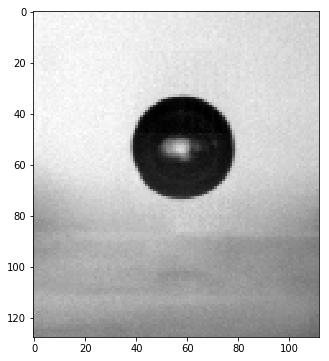

In [2]:
im_in = cv2.imread("bubble images/bubble001.png", cv2.IMREAD_GRAYSCALE)

fig = plt.figure(figsize=(10,6))
plt.imshow(im_in, cmap='gray')

<a id="ch2.1"></a>

### 2.1 Detecting the bubble

The first task is to detect the bubble. The most part of the bubble is dark pixel, except for the center. We can start by converting this "gray scale" image into a "binary" one where the pixel is 0 if bubble and 1 otherwise.

In [3]:
def bubble_detect(im_in, threshold=100):
    '''
    This function convert recorded frames into binary images with bubble's region returned as 1 and 0 otherwise
    
    Inputs:
    threshold -- the threshold below which we identify the pixel as bubble
    im_in -- the image file
    
    Ouputs:
    im_out -- the binary image
    '''
    
    # Detect the center part of the bubble
    th, im_th = cv2.threshold(im_in, threshold, 255, cv2.THRESH_BINARY_INV)
    im_floodfill = im_th.copy()
    im_floodfill = im_th.copy()
    h,w = im_th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0,0), 255)
    
    # Fill the hole with black pixel
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    im_out = im_th+im_floodfill_inv
    im_out = (255-im_out)
    
    return im_out

Text(0.5, 1.0, 'Binary image')

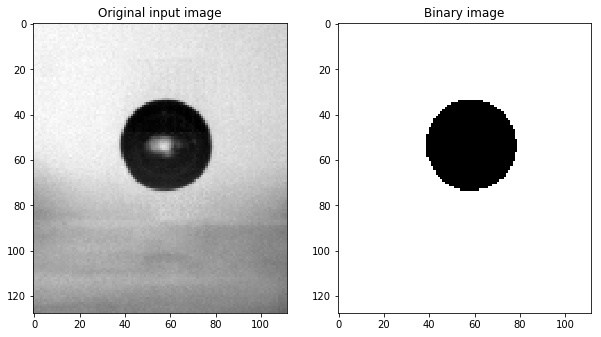

In [4]:
#---------- Plotting the bubble image ----------#

im_bin = bubble_detect(im_in)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(121)
plt.imshow(im_in, cmap='gray')
plt.title('Original input image')
ax = fig.add_subplot(122)
plt.imshow(im_bin, cmap='gray')
plt.title('Binary image')
#plt.tight_layout()

<a id="ch2.2"></a>

### 2.2 Extracting the bubble's effective radius and position

Now that we have obtained the binary image, we can find the bubble's effective radius and the position of its center simply by using a for-loop to sweep along the image's height (or width). Each sweep gives us the volume and position of the disk-shape slice of the bubble. The sum of the disks's volume is that of the bubble. The center's position can be calculated by weight average.

In [5]:
def rad_and_pos(image):
    '''
    This function calculate the effective radius and of the bubble and the position of its center
    
    Arguments:
    image -- the bubble's image in the form of an array of type uint8
    
    Returns:
    R -- the bubble's effective radius (in pixel)
    x_pos, y_pos -- the x, y position of the bubble's center (in pixel)
    '''
    
    # Initiate the variables
    h, w = image.shape 
    V_bubble = 0.
    x_sum = 0.
    y_sum = 0.
    
    # Sweep along vertical line
    for i in range(h): 
        disk = []
        # Sweep along horizontal line
        for j in range(w):
            this_cell = image[i,j]
            if this_cell == 0:
                disk.append(float(j))

        if disk:
            x_disk = np.mean(disk)
            y_disk = i
            r_disk = np.abs(disk[-1]-disk[0])/2
            V_disk = np.pi*r_disk**2*1

            V_bubble = V_bubble+V_disk
            x_sum = x_sum+x_disk*V_disk
            y_sum = y_sum+y_disk*V_disk

    # Sum all the disk to find volume and position
    R = (V_bubble*3/(4*np.pi))**(1/3)
    x_pos = x_sum/V_bubble
    y_pos = y_sum/V_bubble

    return R, x_pos, y_pos

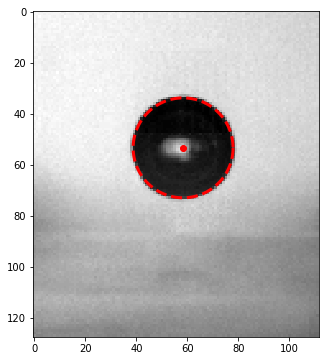

In [6]:
# Extract information from the frame
R, x_pos, y_pos = rad_and_pos(im_bin)

# Plotting the image
alpha = np.linspace(0, 2*np.pi, 200)
x_boundary = R*np.cos(alpha)+x_pos
y_boundary = R*np.sin(alpha)+y_pos

fig = plt.figure(figsize=(10,6))
plt.imshow(im_in, cmap='gray')
plt.plot(x_pos, y_pos, 'o', color='red')
plt.plot(x_boundary, y_boundary, color='red', linewidth=3, linestyle='--')

<a id="ch2.3"></a>

### 2.3 Processing all the frames

The next task is applying the process presented in [section 2.1](#ch2.1) and [section 2.2](#ch2.2) to every frame of the recording

In [7]:
# Collecting all file name of the bubble image

frame_list = []
for file in os.listdir('bubble images'):
    if file.endswith('.png'):
        frame_list.append(file)
        
frame_list.sort()
n_frame = len(frame_list)
R_bubble = np.zeros((n_frame))
x_bubble = np.zeros((n_frame))
y_bubble = np.zeros((n_frame))

# Loop all the frame to extract information in pixel
for i in range(len(frame_list)):
    filename = 'bubble images/'+frame_list[i]
    im_in = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    im_bin = bubble_detect(im_in)
    R, x, y = rad_and_pos(im_bin)
    R_bubble[i] = R
    x_bubble[i] = x
    y_bubble[i] = y
    
    
# Convert from pixel into physical unit
s_pixel = 20 # Size of each pixel is 20um
y_wall = 87 # position of the wall

R_bubble = R_bubble*s_pixel
d_wall = np.abs(y_bubble-y_wall)*s_pixel

Text(0, 0.5, "Bubble's distance from wall [$\\mu$m]")

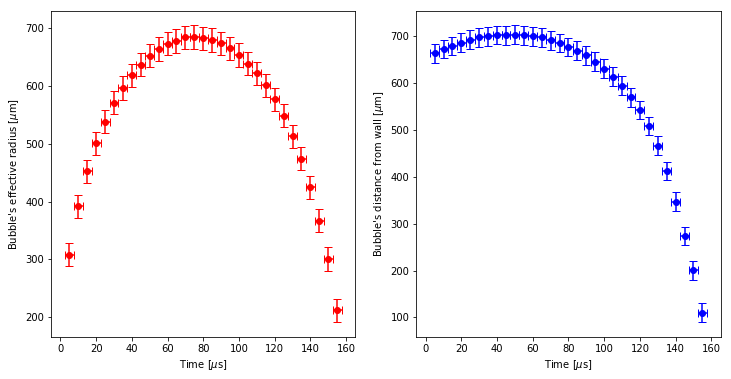

In [8]:
#----------- Plot the evolution of bubble's radius and position on time -----------#

time_step = 1/200000 # Recordinds were taken at 200,000fps
R_err = 1*s_pixel # Uncertatinty is 1 pixel
time_err = time_step/2*1e6

time = np.arange(1,len(R_bubble)+1,1)
time = time*time_step*1e6

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
plt.errorbar(time, R_bubble, xerr=time_err, yerr=R_err, fmt='o', color='red', capsize=4)
plt.xlabel('Time [$\mu$s]')
plt.ylabel("Bubble's effective radius [$\mu$m]")

ax2 = fig.add_subplot(122)
plt.errorbar(time, d_wall, xerr=time_err, yerr=R_err, fmt='o', color='blue', capsize=4)
plt.xlabel('Time [$\mu$s]')
plt.ylabel("Bubble's distance from wall [$\mu$m]")
#plt.tight_layout()

<a id="ch3"></a>

## 3. Mathematical analysis

<a id="ch3.1"></a>

### 3.1 Constructing the mathematical model

To simplify the task, we consider this as a potential flow problem (i.e. we ignore the effect of the liquid's viscosity). The bubble near a solid boundary is thus as if it has a mirror bubble on the other side of the world. The problem turns into studying the interaction between the original bubble and its mirror image.

<img src="mirror_bubble.png" style="width:400;height:300;">
<caption><center> <u> **Figure 1** </u>: **The original bubble and its mirror image**<br> </center></caption>

There has been lots of research on the interactions of multiple oscillating bubble. One highly cited work, based on which we construct our model is [the study by R. Metin et. al.](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.56.2924). The equations and the code below is adapted from prof. Claus-Dieter Ohl works in this [paper](https://onlinelibrary.wiley.com/doi/full/10.1002/adfm.201702618).

Firstly, the bubble's translational movement is affected by Bjerknes force and drag force. The momentum equation for the bubble reads:

$$
\frac{d}{dt}\left(M_i v_i\right) = \frac{d}{dt}\left( \frac{1}{2} \rho V_i v_i\right) = \mathbf{F}_{B,i} + \mathbf{F}_{D,i} \tag{1}
$$

where $V_i = 4/3 \pi R_i^3$ is the volume of the bubble, $\mathbf{F}_{B,i}$ and $\mathbf{F}_{D,i}$ are the secondary Bjerknes force and drag force respectively

Equation (1) thus becomes:

$$
\ddot{\mathbf{x_i}} = \dot{\mathbf{v_i}} = \frac{1}{R_i^3} \left[\frac{3}{2} \frac{1}{\pi\rho}\left(\mathbf{F}_{B,i}+\mathbf{F}_{D,i}\right)-3R_i^2\dot{R_i}\mathbf{v_i}\right] \tag{2}
$$

The secondary Bjerkness force $\mathbf{F}_{B,i}$ is given by:

$$
\mathbf{F}_{B,i} =  \rho V_i \frac{d}{dt} (R_j^2\dot{R}j) \frac{\mathbf{d}_{ij}}{d_{ij}^3} = \frac{4}{3}\pi R_i^3 \rho \left(2R_j\dot{R}_j^2 + R_j^2 \ddot{R}_j \right)\frac{\mathbf{d}_{ij}}{d_{ij}^3} \tag{3}
$$

The drage force $\mathbf{F}_{D,i}$ is given by:

$$
\mathbf{F}_{D,i} = -12 \pi \mu R_i \mathbf{v_i} \tag{4}
$$

Next, to describe the bubble's oscillation, we couple the Keller-Miksis equation with pressure interaction term:

$$
\left(1-\frac{\dot{R}_i}{c}\right) R_i\ddot{R}_i + \left(\frac{3}{2}-\frac{\dot{R_i}}{2c}\right)\dot{R_i}^2 = \frac{1}{\rho}\left(1+\frac{\dot{R_i}}{c}\right)\left(p_l-p_{\infty}\right) + \frac{R_i}{\rho c} \frac{d}{dt} p_l - \frac{1}{d_{ij}}\left(\ddot{R}_j R_j^2 + 2 R_j\dot{R_j^2} \right)\tag{5}
$$

whereas $c$ is the speed of sound and $p_l$ is the liquid pressure at the bubble's wall, which can be calculated as:

$$
p_l = p_{R_i} - \frac{4\mu \dot{R}}{R} - \frac{2S}{R}\tag{6}
$$

Here $p_\infty$ is approximately atmospheric pressure, $\nu$ and $S$ are viscosity and surface tension of the liquid, respectively.

The bubble pressure $p(R_i)$ can be calculated from the initial pressure and radius, assuming the process is adiabatic:

$$
p_{R_i} = p_{R_0}\left(\frac{R_0}{R_i}\right)^{3 \gamma} \tag{7}
$$

Our system has two bubbles: the main bubble and its mirror image. For each bubble there are two unknowns: $R_i$ and $x_i$, thus Eqn. (2) and (5) are sufficient to solve for the problem.

In [9]:
def bubble_ode(y, t):
    '''
    This function is to solve the ode. 
    y -- information about the bubble's radius and velocity at every time step
    
    Returns:
    dy -- the derivatives with respect to time of all variables in y
    
    '''
    n = 2
    R = y[0:n]
    uR = y[n:2*n]
    x = y[2*n:3*n]
    ux = y[3*n:4*n]
    
    dR = np.zeros(shape=R.shape)
    duR = np.zeros(shape=uR.shape)
    dx = np.zeros(shape=x.shape)
    dux = np.zeros(shape=ux.shape)
    
    A = np.zeros((n,n))
    b = np.zeros((n))
    
    # Calculate the evolution of bubble's radius
    for i in range(0,2):
        j = 1-i
        d = np.abs(x[i]-x[j])
        
        pR = p0*(R0/R[i])**(3*gamma)
        pl = pR - 4*mu*uR[i]/R[i] - 2*S/R[i]
        dpl = -pR*3*gamma/R[i]*uR[i] + 4*mu*uR[i]**2/R[i]**2 + 2*S/R[i]**2*uR[i]
        
        b[i] = 1/rho*(1+uR[i]/c)*(pl-p_atm) + R[i]/(rho*c)*dpl - 1/d*2*R[j]*uR[j]**2 - (3/2-uR[i]/(2*c))*uR[i]**2
        A[i,i] = (1-uR[i]/c)*R[i]
        A[j,i] = 1/d*R[j]**2
        
        dR[i] = uR[i]
        
    duR = np.linalg.solve(A,b)
              
    # Calculate bubble's translational movement
    for i in range(0,2):
        V = 4/3*np.pi*R[i]**3
        j = 1-i
        d = np.abs(x[i]-x[j])
        Vdot_i = 4*np.pi*R[i]**2*uR[i]
        Vdot_j = 4*np.pi*R[j]**2*uR[j]
        #F_B = V*rho*(2*R[j]*uR[j]**2 + R[j]**2*duR[j])*(x[i]-x[j]) / d**3
        F_B = -rho/(4*np.pi*d**3)*Vdot_i*Vdot_j*(x[i]-x[j])
        F_D = -12*np.pi*mu*R[i]*ux[i]
        dx[i] = ux[i]
        
        M = 1/2*V*rho
        dM = 1/2*Vdot_i*rho
        
        #dux[i] = 1/R[i]**3*(3/2*1/(np.pi*rho)*(F_B+F_D) - 3*R[i]**2*uR[i]*ux[i])
        if uR[j] == 0:
            derivatives = 0
        else:
             derivatives = duR[j]/uR[j]
        extra_term = 3*M*R[j]**2*uR[j]/d**2*(dM/M + 2*uR[j]/R[j] + derivatives - 2*(ux[i]-ux[j])/d)
        #extra_term = 0
        dux[i] = (F_B + F_D + extra_term - dM*ux[i])/M
        
        # Generate a minimum thickness of the liquid film layer to prevent the bubble from sticking onto the surface
        threshold = 10e-6
        alpha = np.tanh((np.abs(x[i])-R[i]-threshold)/threshold/4)
        dx[i] = dx[i]*alpha + dR[i]*np.sign(x[i])*(1-alpha)
        
    return np.concatenate((dR, duR, dx, dux))

<a id="ch3.2"></a>

### 3.2 Compare the analytical model with experimental data

In [10]:
############### INPUT PARAMETERS ###############

# --------- Fixed constant ---------#
S = 0.072
mu = 8.9e-4
rho = 1000
p_atm = 1.01e5
gamma = 1.4
c = 1450

# -------- Initial conditions ----------#
R0 = 52e-6
p0 = 1.3e8
x0 = 650e-6

Rb0 = np.array([R0,R0])
uR0 = np.array([0,0])
xb0 = np.array([x0, -x0])
ux0 = np.array([0,0])
y0 = np.concatenate((Rb0, uR0, xb0, ux0))

t = np.linspace(0,152e-6,5000)
y = odeint(bubble_ode, y0, t, rtol=1e-8, atol=1e-8)

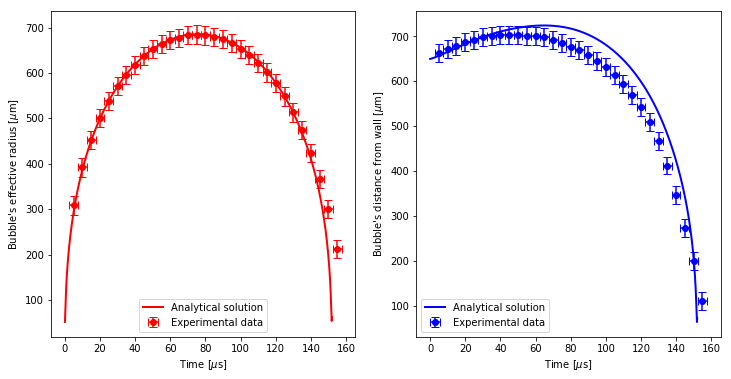

In [11]:
# ---------- Compare analytical model with experimental data -------- #
R_b = y[:,0]*1e6
uR_b = y[:,2]*1e6
d_b = y[:,4]*1e6
t_mus = t*1e6

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
plt.errorbar(time, R_bubble, xerr=time_err, yerr=R_err, fmt='o', color='red', capsize=4, label='Experimental data')
plt.plot(t_mus, R_b, linewidth=2, color='red', label='Analytical solution')
plt.xlabel('Time [$\mu$s]')
plt.ylabel("Bubble's effective radius [$\mu$m]")
plt.legend(loc='best')

ax2 = fig.add_subplot(122)
plt.errorbar(time, d_wall, xerr=time_err, yerr=R_err, fmt='o', color='blue', capsize=4, label='Experimental data')
plt.plot(t_mus, d_b, linewidth=2, color='blue', label='Analytical solution')
plt.xlabel('Time [$\mu$s]')
plt.ylabel("Bubble's distance from wall [$\mu$m]")
plt.legend(loc='best')

The bubble's radius fits very well with experimental data. Its position, however, sees a small difference. This comes from the fact that the bubble is close to the wall in this case and can no longer maintain a spherical shape during the collapse, which violates our assumption. The effect of viscosity is also more significant in this region. Neverthelss, it can describe quantitatively well the dynamics of the bubble.

<a id="ch3.3"></a>

### 3.3 The flow profile of the liquid

The bubble and its mirror images are the two source of the potential flow. The flow profile created can be expressed as:

$$
\mathbf{v_i} = \sum_{i} \left(R_i^2 \dot{R_i} \frac{\mathbf{r}}{r^3} + \mathbf{u}_i \right)
$$

where $\mathbf{r}$ is the position of the point in consideration relative to the source.

In [12]:
def velocity_field(Rb, uRb, distance, w, h, nx, ny, plot=True):
    '''
    This function return the velocity field of the fluid around the bubble knowing its radius and
    distance from the wall
    
    Arguments:
    Rb -- the bubble's effective radius
    uR -- velocity of the bubble's wall
    distance -- distance between the bubble and the wall
    h -- the height of the field in consideration
    w -- the width of the field in consideration
    nx, ny -- density of the grid for the plot
    
    Returns:
    u, v -- matrices contain the x and y components of the velocity field
    '''
    
    # Generate the geometry meshgrid:
    x = np.linspace(-w/2, w/2, nx)
    y = np.linspace(0, h, ny)
    X, Y = np.meshgrid(x,y)
    
    # Generate the velocity grid
    u = np.zeros((ny, nx))
    v = np.zeros((ny, nx))
    
    for i in range(nx):
        for j in range(ny):
            r1 = np.sqrt(X[i,j]**2 + (Y[i,j]-distance)**2)
            r2 = np.sqrt(X[i,j]**2 + (Y[i,j]+distance)**2)
            if r1<Rb:
                u[i,j] = 0
                v[i,j] = 0
            else:
                u[i,j] = Rb**2*uRb*X[i,j]/r1**3 + Rb**2*uRb*X[i,j]/r2**3
                v[i,j] = Rb**2*uRb*((Y[i,j]-distance)/r1**3 + (Y[i,j]+distance)/r2**3)
    
    # Plot the flow profile
    if plot==True:
        alpha = np.linspace(0,2*np.pi,200)
        x_b = Rb*np.cos(alpha)
        y_b = Rb*np.sin(alpha) + distance
        plt.plot(x_b, y_b, linewidth=3, color='blue')
        #plt.streamplot(X[::1,::1], Y[::1,::1], u[::1,::1], v[::1,::1])
        plt.axhline(y=0, linewidth=2, color='black')
        plt.quiver(X[::1,::1], Y[::1,::1], u[::1,::1], v[::1,::1],0, color='blue', scale=5e4, scale_units='xy')
        plt.xlabel('X [$\mu$m]')
        plt.ylabel('Y [$\mu$m]')
    
    return u, v

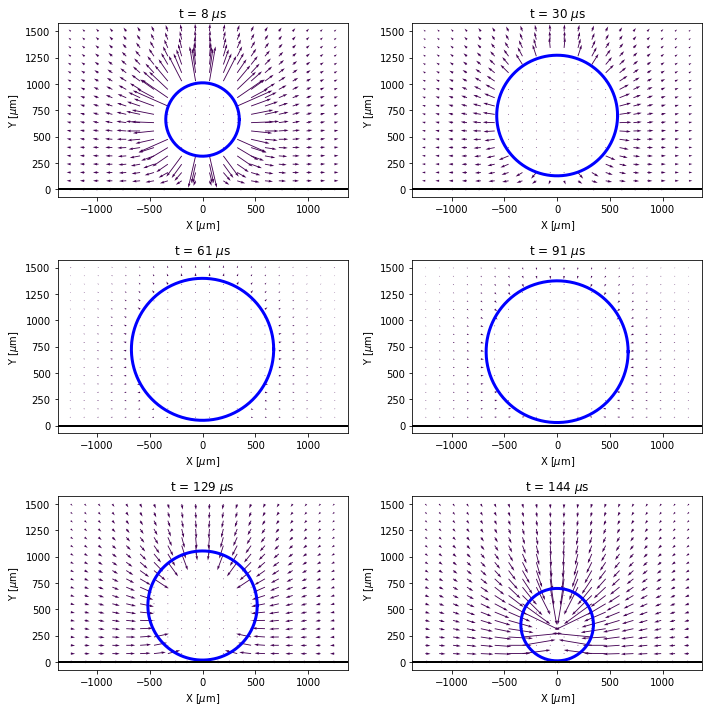

In [13]:
# --------- Plot the flow profile of different time frame ----------- #
w = 2500
h = 1500
nx = 20
ny = 20

t_plot = np.array([0.05, 0.2, 0.4, 0.6, 0.85, 0.95])
t_plot = t_plot*len(t_mus)

fig = plt.figure(figsize=(10,10))
for t in range(len(t_plot)):
    i = int(t_plot[t])
    ax = fig.add_subplot(3,2,t+1)
    u,v = velocity_field(R_b[i], uR_b[i], d_b[i], w, h, nx, ny)
    plt.title('t = %.0f $\mu$s'%t_mus[i])
    
plt.tight_layout()
